# 0. Preparatory work

## 0.1. Install libraries

In [1]:
!pip3 install numpy pandas matplotlib scikit-learn keras

## 0.2. Import libraries

In [2]:
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np

# 1. The data

Rosbank Insurance (one of the major insurance companies in Russia) is selling mortgage insurance policies to its clients via partners A, B and C.

One of them (partner A) has established process of upsale to clients additional box property insurance product. According to statistics, around 30% of clients agree to buy it, others reject.

Management of the company wants to implement upsale process for clients came via partners B and C. Employees of Rosbank Insurance should make calls to these clients and offer box property product.

However, addressing all clients having maximum 30% success rate is considered ineffective. Hence it is required to develop ML model which will highlight clients who looks more inclined to agree for the deal. This model will be trained and tested on clients came via partner A, and then used to find candidates for upsale within clients came from partners B and C.

Since it is critical to identify as many clients who may want to but the box product as possible, two main targets were set for the model:

1. It should achieve not less than 66% accuracy, so the model works for 2/3 of clients.
2. It should produce as low number of false negatives as possible. Each false negative means we do not address client who may decide to buy the product.


## 1.1. Upload data

Our dataset is obtain from Rosbank Insurance database. It is csv file separated by ';'. 

There are three columns with dates in format "dd.mm.YYYY", which needs to be specifically handled while reading the file.

In [3]:
path = '/Users/nikolaygospodarik/csm010-aml-coursework-ngospodarik/Mortgage.csv'

df = pd.read_csv(path, delimiter=';', parse_dates = ['Agreement date', 'End date', 'Date of birth'], dayfirst = True)

# dataset contains 13656 lines and 11 columns. Let's check upload is successful: 

assert df.shape == (13656,11)


In [4]:
# print info about dataframe and its columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Marketing region        13656 non-null  object        
 1   Agreement date          13656 non-null  datetime64[ns]
 2   End date                13656 non-null  datetime64[ns]
 3   Duration                13656 non-null  int64         
 4   Initial loan principal  13656 non-null  float64       
 5   Paid premium            13656 non-null  float64       
 6   Insurance program       13656 non-null  object        
 7   Gender                  13656 non-null  object        
 8   Date of birth           13656 non-null  datetime64[ns]
 9   Profession risk level   13656 non-null  object        
 10  Has_box_product         13656 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
# print info about missing values

df.isnull().sum()

Marketing region          0
Agreement date            0
End date                  0
Duration                  0
Initial loan principal    0
Paid premium              0
Insurance program         0
Gender                    0
Date of birth             0
Profession risk level     0
Has_box_product           0
dtype: int64

We have 11 columns, out of them 10 are features, and 1 ('Has_box_product') is the target variable. There are no missing values in the dataset.

There is date of birth in the dataset, however the age is missing. Let's create this attribute.

In [6]:
# fix current date

now = pd.Timestamp('now')

# add new column right after date of birth, and fill it with difference in full years between now and date of birth

df.insert(loc=9, column='Age', value=(now - df['Date of birth']).astype('timedelta64[Y]'))

And then re-print info on the set.

In [7]:
# re-print info about dataframe and its columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Marketing region        13656 non-null  object        
 1   Agreement date          13656 non-null  datetime64[ns]
 2   End date                13656 non-null  datetime64[ns]
 3   Duration                13656 non-null  int64         
 4   Initial loan principal  13656 non-null  float64       
 5   Paid premium            13656 non-null  float64       
 6   Insurance program       13656 non-null  object        
 7   Gender                  13656 non-null  object        
 8   Date of birth           13656 non-null  datetime64[ns]
 9   Age                     13656 non-null  float64       
 10  Profession risk level   13656 non-null  object        
 11  Has_box_product         13656 non-null  int64         
dtypes: datetime64[ns](3), float64(3), int64(2), ob

Since we have Duration (which is difference in days between Agreement date and End date), and also Age (difference between today and Date of Birth), we do not need anymore datetime columns, and it can be dropped without lose of information.

In [8]:
df = df.drop(columns=['Agreement date', 'End date', 'Date of birth'])

In [9]:
# re-print info about dataframe and its columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Marketing region        13656 non-null  object 
 1   Duration                13656 non-null  int64  
 2   Initial loan principal  13656 non-null  float64
 3   Paid premium            13656 non-null  float64
 4   Insurance program       13656 non-null  object 
 5   Gender                  13656 non-null  object 
 6   Age                     13656 non-null  float64
 7   Profession risk level   13656 non-null  object 
 8   Has_box_product         13656 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 960.3+ KB


So we end up with 9 columns: 8 features and 1 target.

## 1.2. Data factorization

As we see, several columns ('Marketing region', 'Insurance programm', 'Gender', 'Profession risk level') are categorical, so they contain categories stored as strings. To proceed, we need first to convert these values to integers, which could be done using factorize function of pandas library.

In [10]:
# select categorical columns

cat_columns = df.select_dtypes(['object']).columns

# factorize the selected columns

df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [11]:
# re-print info about dataframe and its columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13656 entries, 0 to 13655
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Marketing region        13656 non-null  int64  
 1   Duration                13656 non-null  int64  
 2   Initial loan principal  13656 non-null  float64
 3   Paid premium            13656 non-null  float64
 4   Insurance program       13656 non-null  int64  
 5   Gender                  13656 non-null  int64  
 6   Age                     13656 non-null  float64
 7   Profession risk level   13656 non-null  int64  
 8   Has_box_product         13656 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 960.3 KB


## 1.3. Descriptive statistics

First let's make stastistical summary for all columns in the file.

In [12]:
description = df.describe()

description

,Marketing region,Duration,Initial loan principal,Paid premium,Insurance program,Gender,Age,Profession risk level,Has_box_product
count,13656.000000,13656.000000,1.365600e+04,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000,13656.000000
mean,7.025630,8346.455770,5.053559e+06,28941.155042,1.118849,0.472613,36.601714,0.328427,0.283905
std,10.293108,2845.476012,4.068582e+06,30888.329857,0.557897,0.499268,7.858790,0.729059,0.450908
min,0.000000,365.000000,2.081690e+05,452.100000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,1.000000,6331.000000,2.400000e+06,12500.772500,1.000000,0.000000,31.000000,0.000000,0.000000
50%,4.000000,8159.000000,4.125395e+06,20893.790000,1.000000,0.000000,36.000000,0.000000,0.000000
75%,6.000000,11079.000000,6.300000e+06,34661.250000,1.000000,1.000000,42.000000,0.000000,1.000000
max,61.000000,12907.000000,5.000000e+07,647500.000000,2.000000,1.000000,61.000000,2.000000,1.000000


Since we are facing a classification problem, another important step is to assess how balanced are classes for the target variable in the dataset.

In [13]:
class_counts = df.groupby('Has_box_product').size()

class_counts

Has_box_product
0    9779
1    3877
dtype: int64

There are 2 classes. Classes are unbalanced, there are appr. 3 times more clients without box product than clients who have one. It may significantly impact results, making models prone to bias.

We need to rebalance dataset, so that there is 50/50 rows with 0s and 1s.

In [14]:
# first we slice all 1s from the original dataframe

ones = df[df['Has_box_product']==1]

# then we randomly slice same number of 0s

zeros = df[df['Has_box_product']==0].sample(ones.shape[0])

# concatenate 1s and 0s in new dataframe

df = pd.concat([ones,zeros])

# reprint new class counts

class_counts = df.groupby('Has_box_product').size()

class_counts


Has_box_product
0    3877
1    3877
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7754 entries, 3 to 3175
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Marketing region        7754 non-null   int64  
 1   Duration                7754 non-null   int64  
 2   Initial loan principal  7754 non-null   float64
 3   Paid premium            7754 non-null   float64
 4   Insurance program       7754 non-null   int64  
 5   Gender                  7754 non-null   int64  
 6   Age                     7754 non-null   float64
 7   Profession risk level   7754 non-null   int64  
 8   Has_box_product         7754 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 605.8 KB


Next step is to measure correlation within numeric values of the dataset.

In [16]:
correlations = df.corr(method='pearson')

correlations

,Marketing region,Duration,Initial loan principal,Paid premium,Insurance program,Gender,Age,Profession risk level,Has_box_product
Marketing region,1.000000,-0.060888,-0.199234,-0.155500,-0.005408,-0.022471,-0.032702,0.063477,0.007378
Duration,-0.060888,1.000000,0.208771,-0.033386,0.110274,-0.048001,-0.409321,0.052062,-0.017639
Initial loan principal,-0.199234,0.208771,1.000000,0.800967,0.118733,-0.065803,0.024605,-0.164115,-0.080437
Paid premium,-0.155500,-0.033386,0.800967,1.000000,-0.034487,-0.145877,0.303295,-0.119298,0.037120
Insurance program,-0.005408,0.110274,0.118733,-0.034487,1.000000,-0.003978,0.004555,-0.043339,-0.269079
Gender,-0.022471,-0.048001,-0.065803,-0.145877,-0.003978,1.000000,0.139604,-0.124602,0.014974
Age,-0.032702,-0.409321,0.024605,0.303295,0.004555,0.139604,1.000000,-0.056808,-0.053432
Profession risk level,0.063477,0.052062,-0.164115,-0.119298,-0.043339,-0.124602,-0.056808,1.000000,0.093432
Has_box_product,0.007378,-0.017639,-0.080437,0.037120,-0.269079,0.014974,-0.053432,0.093432,1.000000


For our target column we don't see highly correlated attributes (with correlation > 0.5 or <-0.5).

Calculation of skew for each of the attribute shows how close to Gaussian distribution it is. 

In [17]:
skew = df.skew()

skew

Marketing region          2.357763
Duration                 -0.275986
Initial loan principal    3.141089
Paid premium              4.317399
Insurance program         0.130358
Gender                    0.087281
Age                       0.329600
Profession risk level     1.729773
Has_box_product           0.000000
dtype: float64

Majority of the features are skewed positively, with one (Duration) skewed negatively. Normal distribution is important for some algorithms, such as logistic regression, so normalization would be required.

## 1.4. Data visualization

As a first step we will draw histogram to analyse distribution of the features.

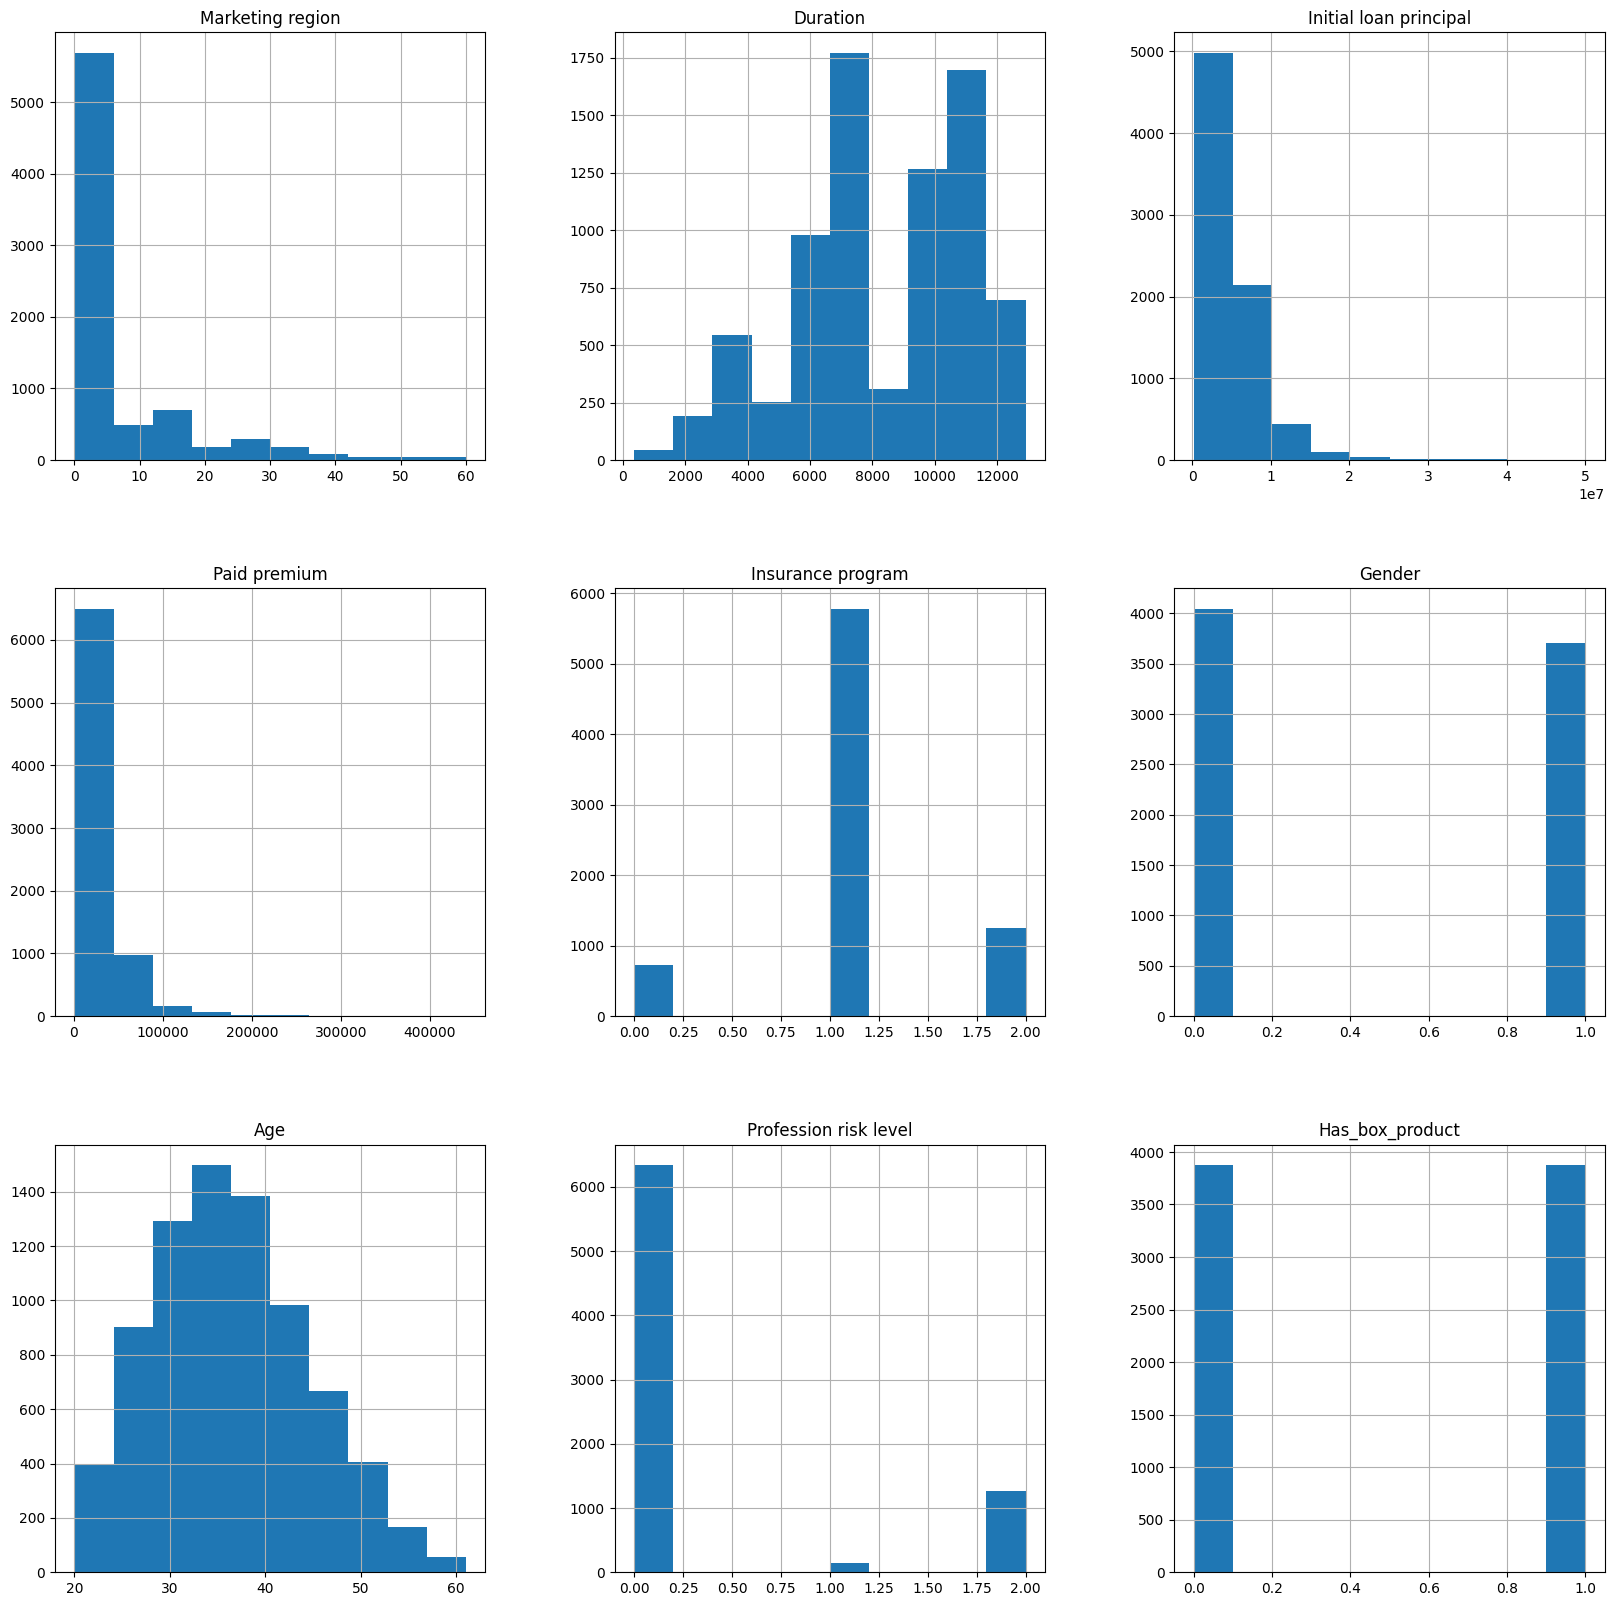

In [18]:
# Univariate Histograms

df.hist(figsize=[20, 20])
pyplot.show()

On the histogram we can also see that most features are skewed.

Another way of make a quick view on the features is density plot. However it works only for features with int64 type.

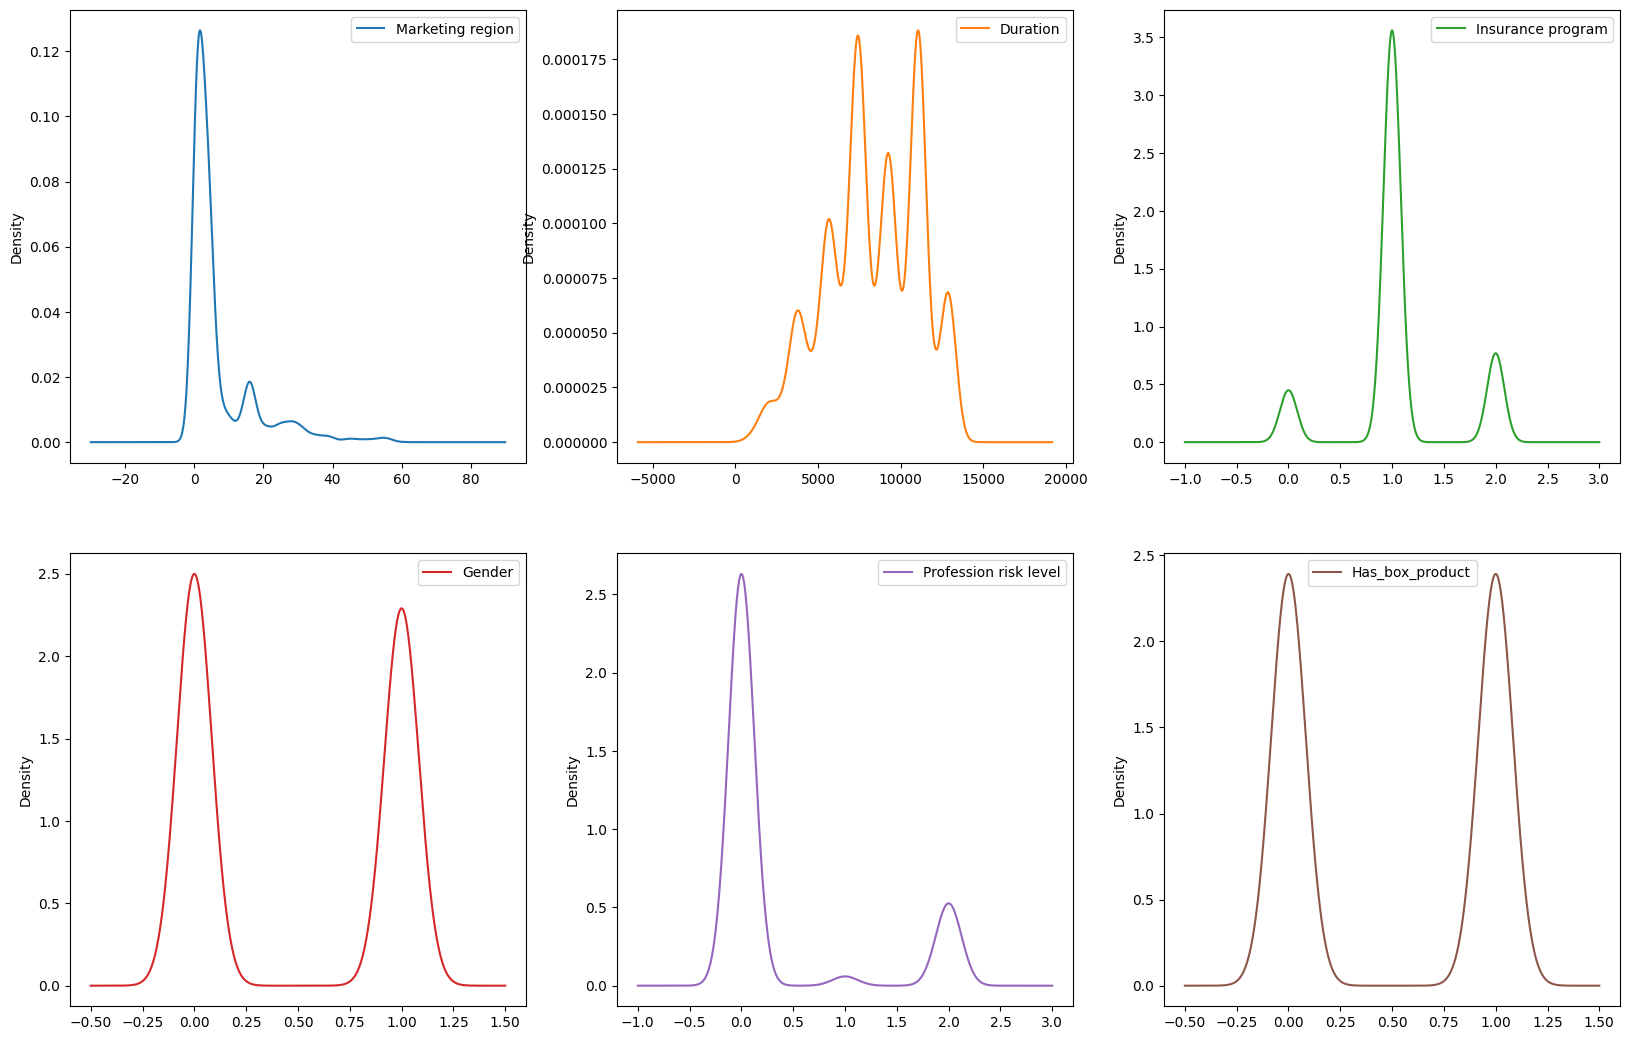

In [19]:
# select columns with int64 type

int_columns = df.select_dtypes(['int64']).columns

# create a plot

df[int_columns].plot(kind='density', subplots=True, layout=(3,3), sharex=False,figsize=[20, 20]) 
pyplot.show()

Next way is to build a box and whisker plots that will show the spread of the data and outliers.

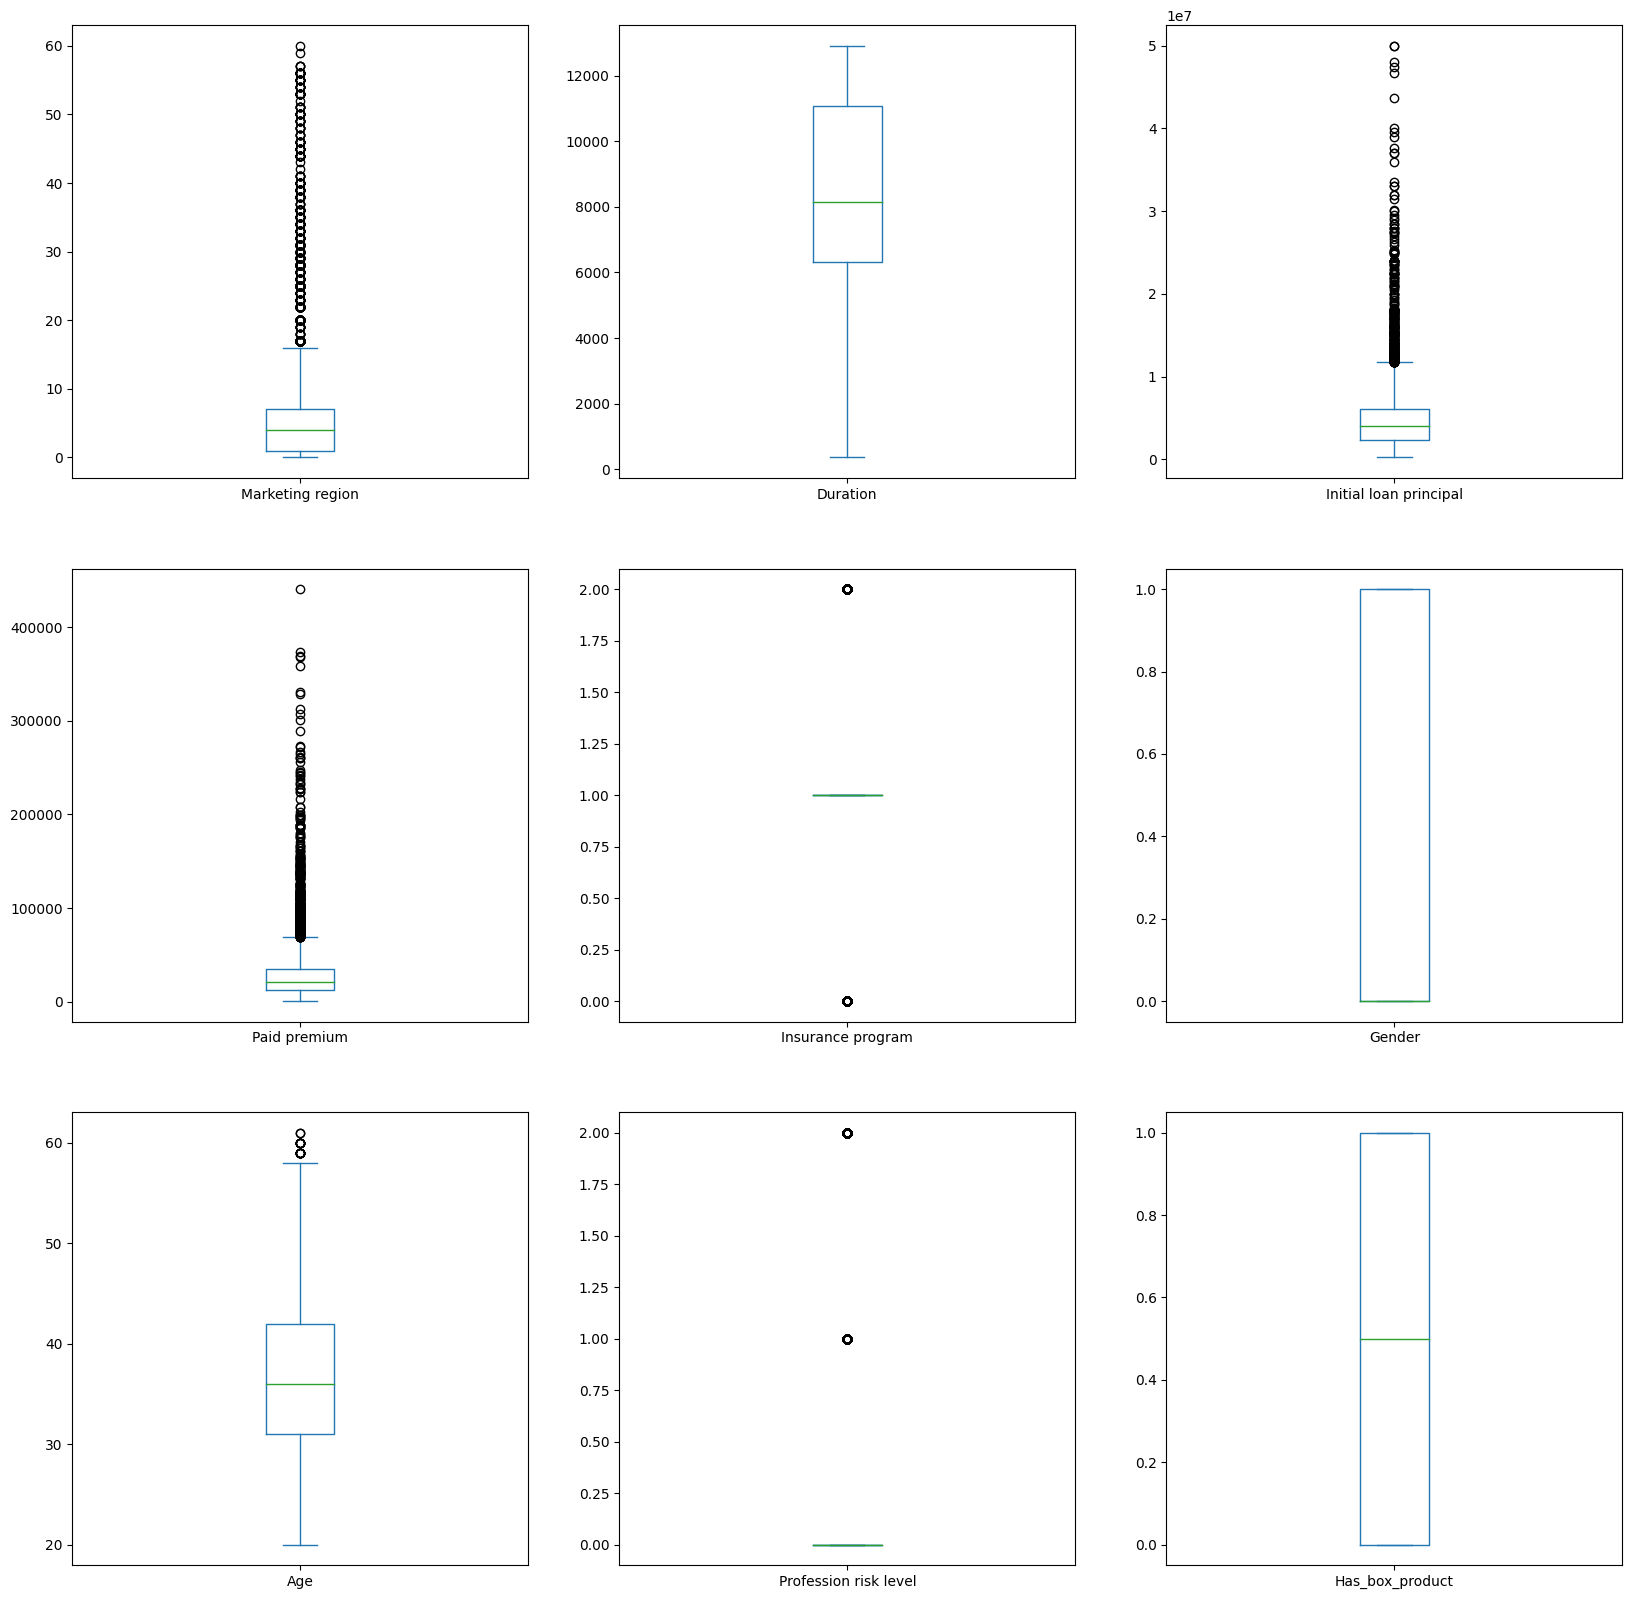

In [20]:
# Box and Whisker Plots

df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False,figsize=[20, 20]) 
pyplot.show()

Box and whiskers plot shows that features have completely different scales, and needs to be rescaled.

Good practice is also to visualize correlation matrix, to see graphically correlation between target variable and features of the dataset.

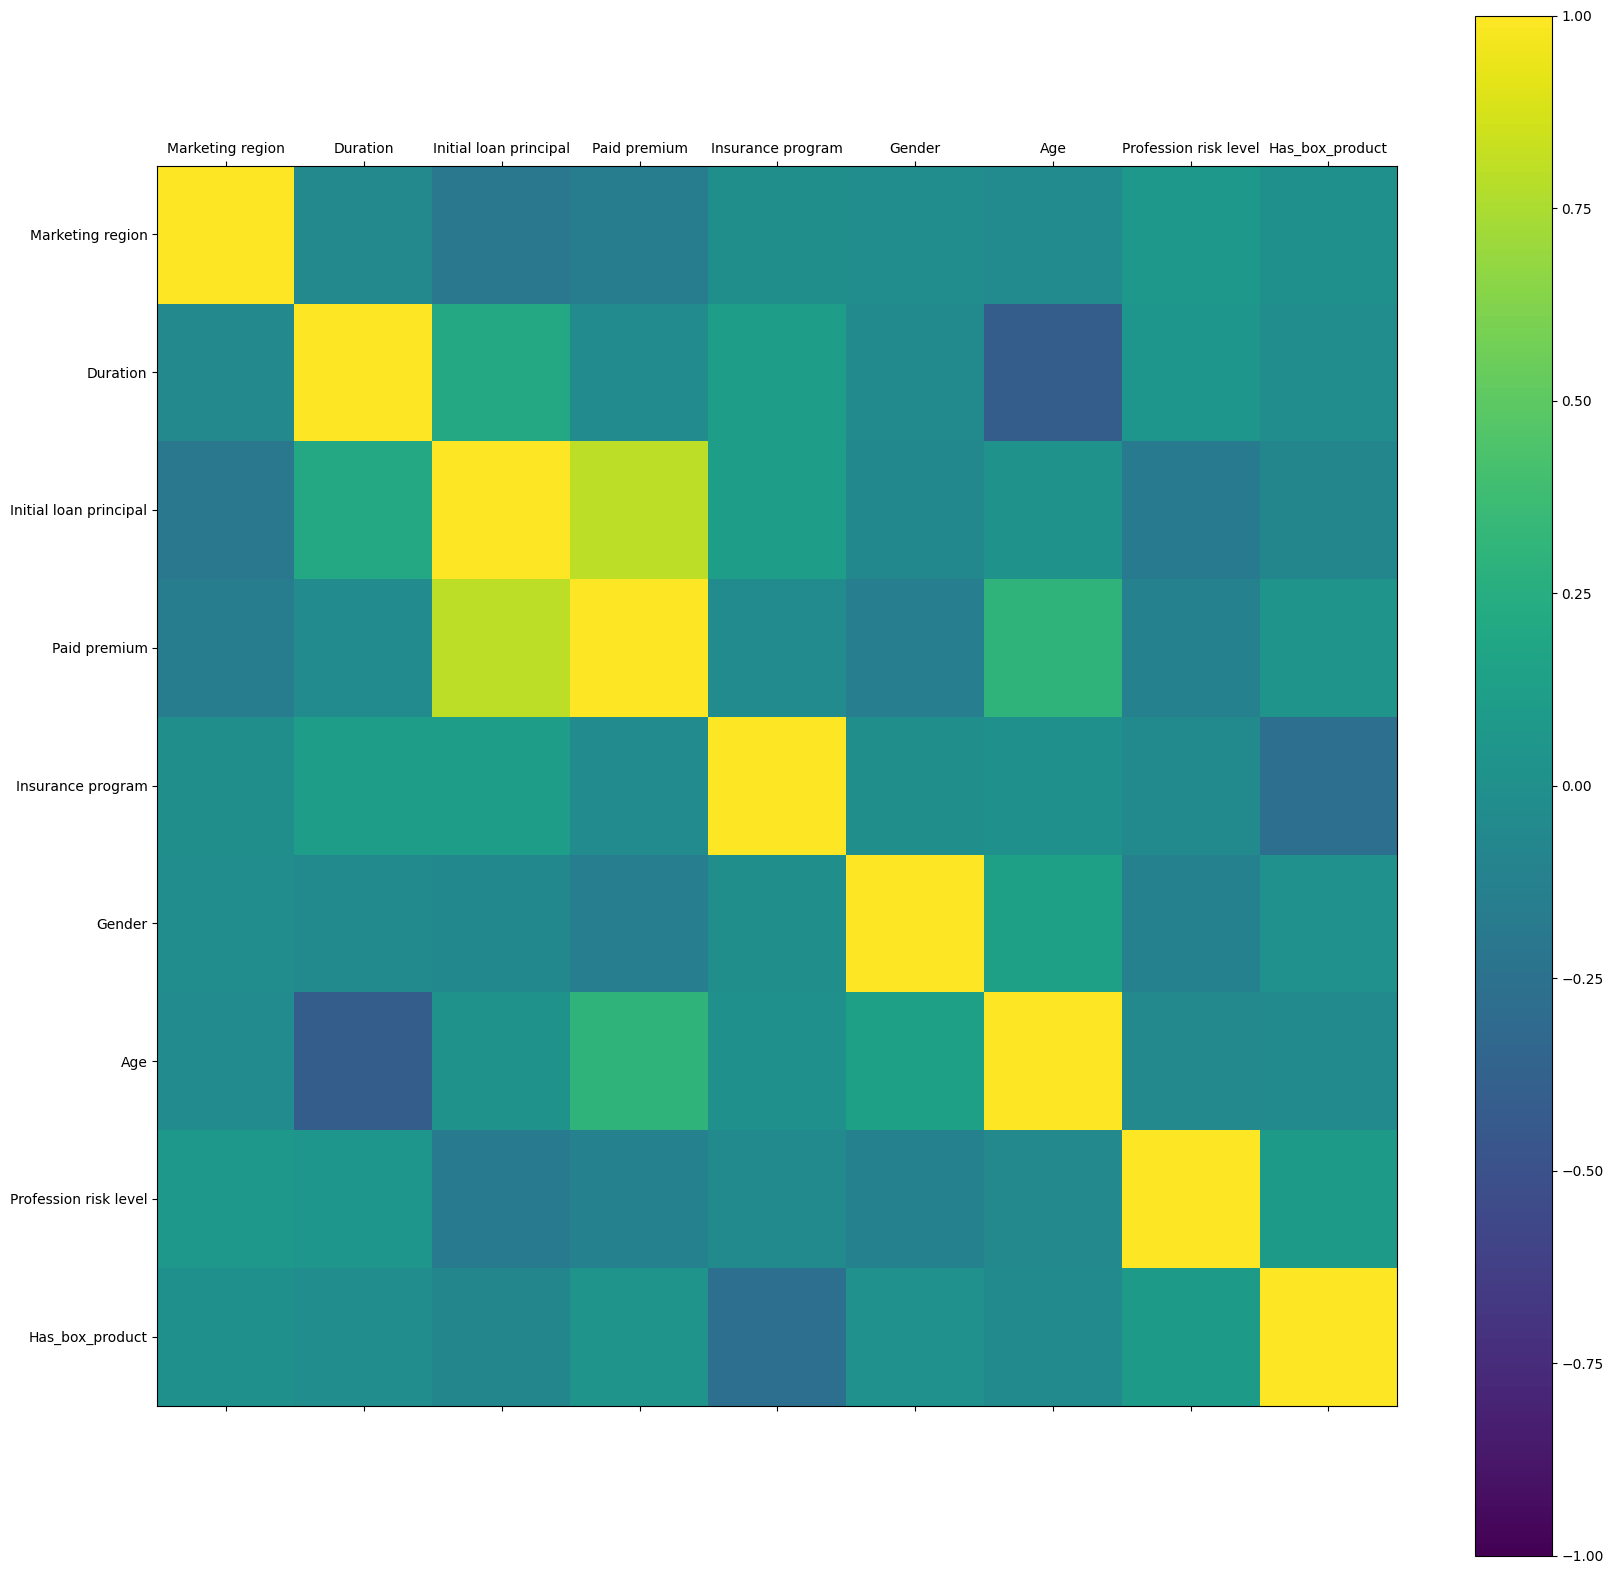

In [21]:
# Correlation Matrix Plot

# create correlation matrix

correlations = df.corr()

# plot correlation matrix
fig = pyplot.figure(figsize=[20, 20])
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,9,1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)


# add names to the plot

names = list(df.columns.values)

ax.set_xticklabels(names)
ax.set_yticklabels(names)

pyplot.show()

Finally, another way of represenation of scatterplot which also allows to have an overview of how correlated are our features and target value.

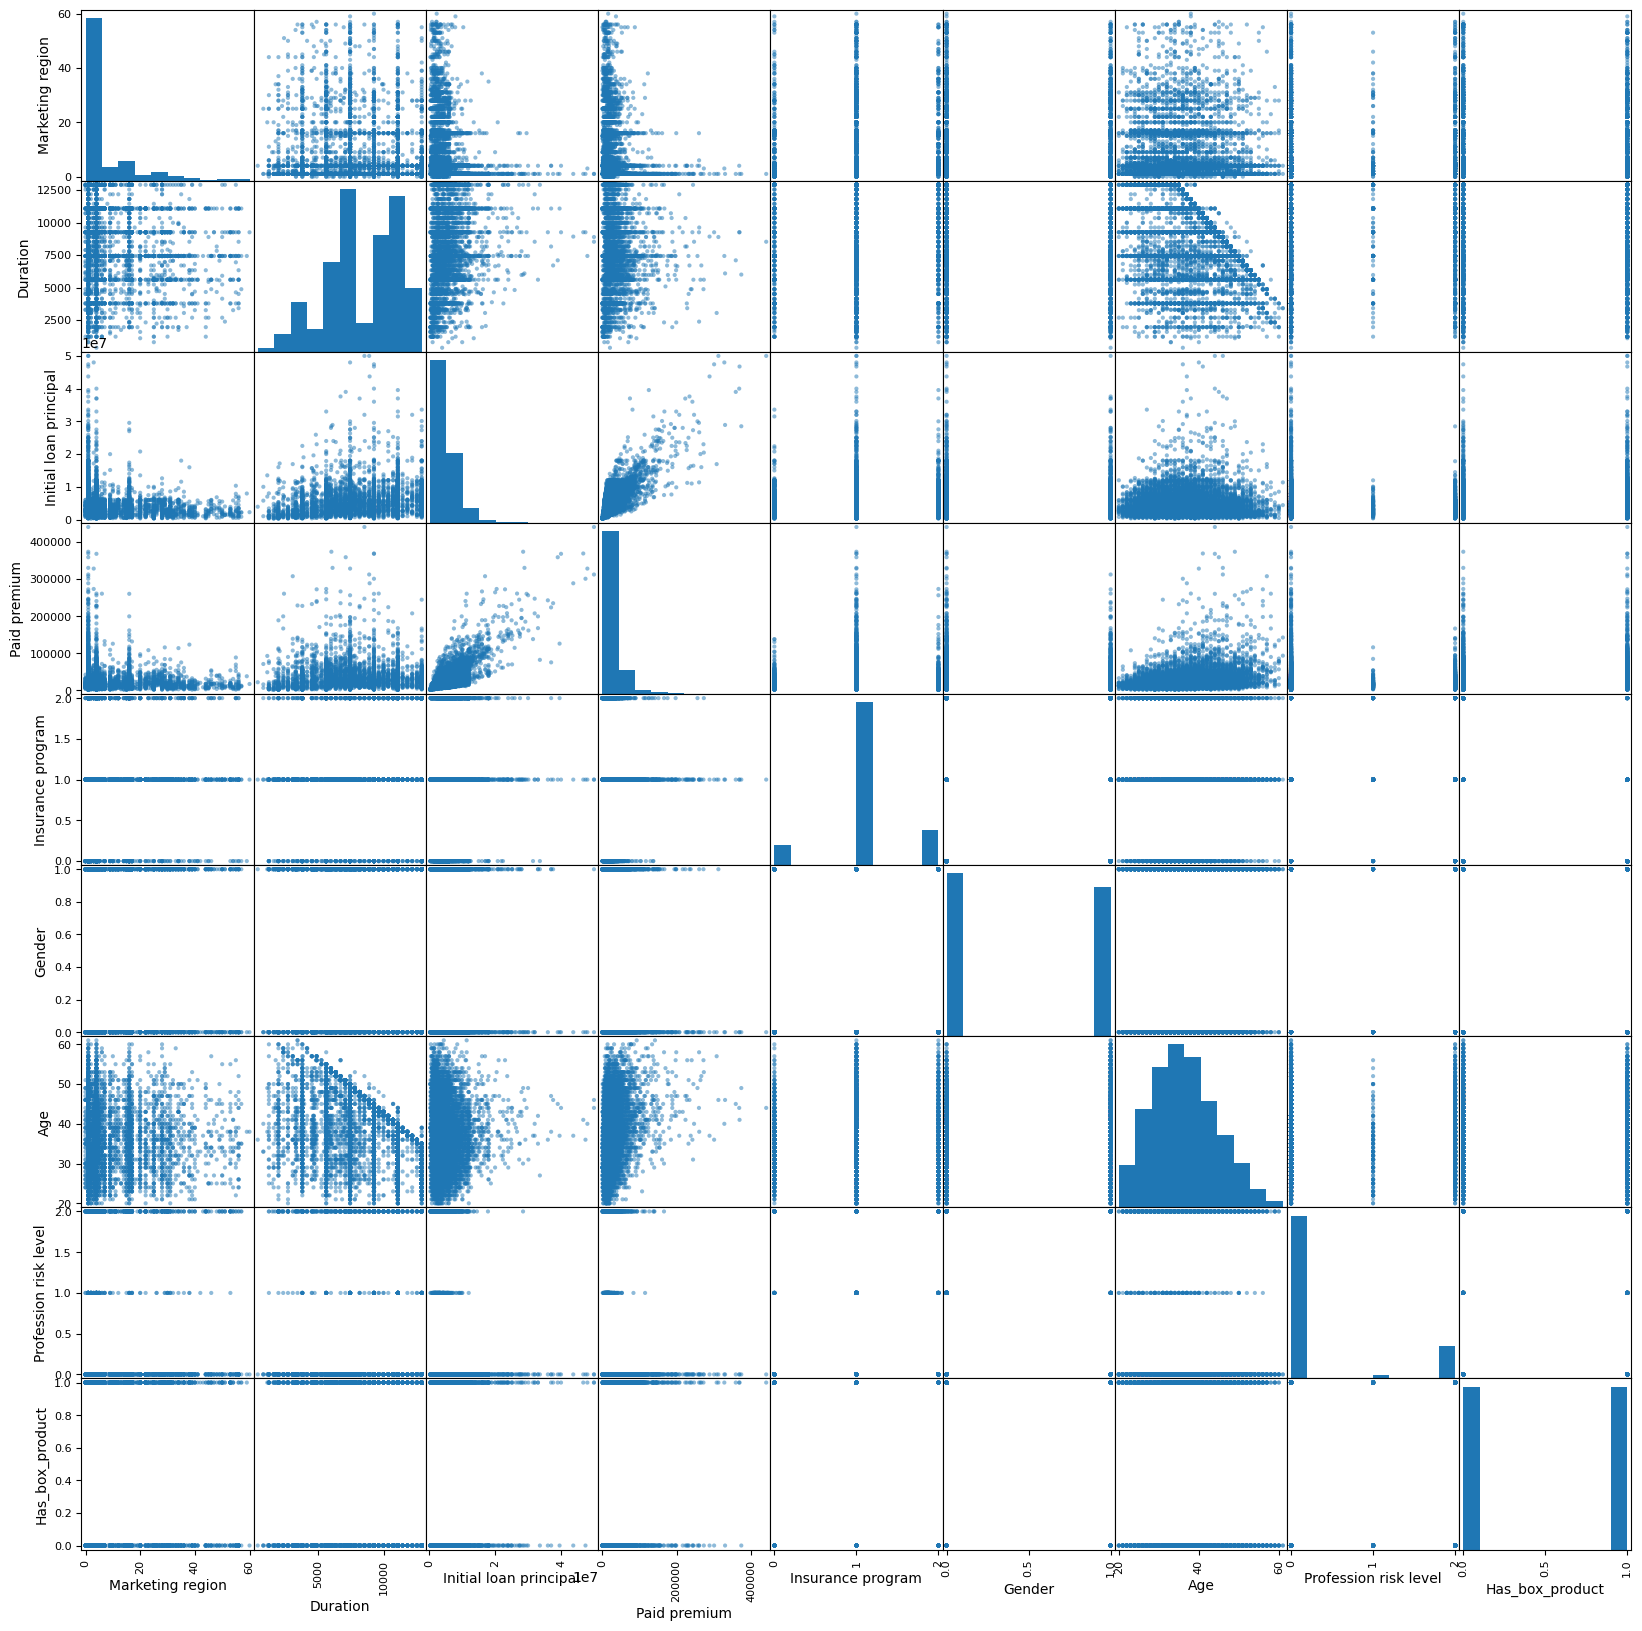

In [22]:
# Scatterplot Matrix using Pandas

pd.plotting.scatter_matrix(df, figsize=[20, 20])

pyplot.show()

Again, we see that there are no features highly correlated with target column, which is good, since in other case it could lead to bias while modeling.

## 1.5. Data transformation

As a first step, we separate dataset to features and target value.

In [23]:
# extract values
array = df.values

# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]


Then we transform the input data using various techniques.

In [24]:
# Rescale data (between 0 and 1)
from numpy import set_printoptions
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

# summarize transformed data
set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[0.033 0.417 0.016 0.011 0.5   1.    0.415 0.   ]
 [0.05  0.709 0.13  0.105 0.5   0.    0.341 0.   ]
 [0.067 0.709 0.081 0.075 0.    0.    0.341 0.   ]
 [0.083 0.621 0.026 0.019 0.5   0.    0.317 0.   ]
 [0.017 0.709 0.235 0.243 0.5   1.    0.073 0.   ]]


In [25]:
# Standardise data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
standardX = scaler.fit_transform(X)

# summarise transformed data
set_printoptions(precision=3)
print(standardX[0:5,:])

[[-0.495 -0.971 -0.975 -0.798 -0.134  1.045  0.064 -0.465]
 [-0.396  0.33   0.431  0.587 -0.134 -0.957 -0.316 -0.465]
 [-0.297  0.33  -0.175  0.146 -2.132 -0.957 -0.316 -0.465]
 [-0.198 -0.061 -0.851 -0.672 -0.134 -0.957 -0.442 -0.465]
 [-0.594  0.33   1.717  2.624 -0.134  1.045 -1.707 -0.465]]


In [26]:
# Normalise data (length of 1)

from sklearn.preprocessing import Normalizer 

scaler = Normalizer().fit(X)

normalizedX = scaler.transform(X)

# summarize transformed data
set_printoptions(precision=3)
print(normalizedX[0:5,:])

[[2.000e-06 5.601e-03 1.000e+00 5.598e-03 1.000e-06 1.000e-06 3.700e-05
  0.000e+00]
 [4.482e-07 1.382e-03 1.000e+00 7.016e-03 1.494e-07 0.000e+00 5.079e-06
  0.000e+00]
 [9.436e-07 2.183e-03 1.000e+00 7.972e-03 0.000e+00 0.000e+00 8.020e-06
  0.000e+00]
 [3.333e-06 5.438e-03 1.000e+00 6.252e-03 6.666e-07 0.000e+00 2.200e-05
  0.000e+00]
 [8.403e-08 7.775e-04 1.000e+00 9.057e-03 8.403e-08 8.403e-08 1.933e-06
  0.000e+00]]


# 2. Constructing and Selecting Features

## 2.1. Filter-based method

First method is chi-squared ( 𝜒2 ) statistical test for top-4 features of the dataset.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores
set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(fit.scores_)
features = fit.transform(X)

# summarize selected features
print(features[0:5,:])

[ 6.152  2282.475  166352096.157  323544.995  131.762  0.907  37.926
  108.363]
[[ 5601.000  1000000.000  5598.000  1.000]
 [ 9253.000  6694000.000  46963.690  1.000]
 [ 9253.000  4239000.000  33794.170  0.000]
 [ 8158.000  1500000.000  9378.000  1.000]
 [ 9253.000  11900000.000  107778.170  1.000]]


Using chi2 on non-rescaled data returns inadeqaute results and score for some of the features. So let's run it on rescaled X.

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(rescaledX, Y)

# summarize scores
set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(fit.scores_)
features = fit.transform(rescaledX)

# summarize selected features
print(features[0:5,:])

[ 0.103  0.190  3.488  0.759  65.881  0.907  2.047  54.181]
[[ 0.016  0.500  0.415  0.000]
 [ 0.130  0.500  0.341  0.000]
 [ 0.081  0.000  0.341  0.000]
 [ 0.026  0.500  0.317  0.000]
 [ 0.235  0.500  0.073  0.000]]


Let's build dataframe for better visualization of results.

In [29]:
feature_selection_df = pd.DataFrame(fit.scores_,index=names[:8],columns=['Chi2 score'])

feature_selection_df

,Chi2 score
Marketing region,0.102528
Duration,0.190328
Initial loan principal,3.487705
Paid premium,0.758932
Insurance program,65.881044
Gender,0.907228
Age,2.046602
Profession risk level,54.181462


So features with highest scores are: Initial loan principal, Insurance program, Age, Profession risk level.

## 2.2 Wrapper-based method

Another approach is to use backward selection (also known as Recursive Feature Elimination). Here again we will try to see perfomance on raw data and on transformed data.

In [30]:
# RFE for raw X

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression(solver='liblinear')

rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(X, Y)

print("Num Features: %d" % fit.n_features_)

print("The feature labels: %s " % names)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
The feature labels: ['Marketing region', 'Duration', 'Initial loan principal', 'Paid premium', 'Insurance program', 'Gender', 'Age', 'Profession risk level', 'Has_box_product'] 
Selected Features: [False  True  True  True False False  True False]
Feature Ranking: [4 1 1 1 2 5 1 3]


In [31]:
# add results to our dataframe with feature assement

feature_selection_df['Raw RFE selected'] = fit.support_
feature_selection_df['Raw RFE ranking'] = fit.ranking_

In [32]:
# RFE for rescaled X

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression(solver='liblinear')

rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(rescaledX, Y)

print("Num Features: %d" % fit.n_features_)
print("The feature labels: %s " % names)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 4
The feature labels: ['Marketing region', 'Duration', 'Initial loan principal', 'Paid premium', 'Insurance program', 'Gender', 'Age', 'Profession risk level', 'Has_box_product'] 
Selected Features: [False False  True  True  True False  True False]
Feature Ranking: [5 4 1 1 1 3 1 2]


In [33]:
# add results to our dataframe with feature assement

feature_selection_df['Rescaled RFE selected'] = fit.support_
feature_selection_df['Rescaled RFE ranking'] = fit.ranking_

In [34]:
# RFE for standartized X

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression(solver='liblinear')

rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(standardX, Y)

print("Num Features: %d" % fit.n_features_)
print("The feature labels: %s " % names)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 4
The feature labels: ['Marketing region', 'Duration', 'Initial loan principal', 'Paid premium', 'Insurance program', 'Gender', 'Age', 'Profession risk level', 'Has_box_product'] 
Selected Features: [False False  True  True  True False  True False]
Feature Ranking: [5 4 1 1 1 2 1 3]


In [35]:
# add results to our dataframe with feature assement

feature_selection_df['Standartized RFE selected'] = fit.support_
feature_selection_df['Standartized RFE ranking'] = fit.ranking_

In [36]:
# RFE for normalized X

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# feature extraction
model = LogisticRegression(solver='liblinear')

rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(normalizedX, Y)

print("Num Features: %d" % fit.n_features_)
print("The feature labels: %s " % names)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
The feature labels: ['Marketing region', 'Duration', 'Initial loan principal', 'Paid premium', 'Insurance program', 'Gender', 'Age', 'Profession risk level', 'Has_box_product'] 
Selected Features: [False  True  True  True False False  True False]
Feature Ranking: [4 1 1 1 3 5 1 2]


In [37]:
# add results to our dataframe with feature assement

feature_selection_df['Normalized RFE selected'] = fit.support_
feature_selection_df['Normalized RFE ranking'] = fit.ranking_

Print dataframe with all scores for chi2 and RFE.

In [38]:
feature_selection_df

,Chi2 score,Raw RFE selected,Raw RFE ranking,Rescaled RFE selected,Rescaled RFE ranking,Standartized RFE selected,Standartized RFE ranking,Normalized RFE selected,Normalized RFE ranking
Marketing region,0.102528,False,4,False,5,False,5,False,4
Duration,0.190328,True,1,False,4,False,4,True,1
Initial loan principal,3.487705,True,1,True,1,True,1,True,1
Paid premium,0.758932,True,1,True,1,True,1,True,1
Insurance program,65.881044,False,2,True,1,True,1,False,3
Gender,0.907228,False,5,False,3,False,2,False,5
Age,2.046602,True,1,True,1,True,1,True,1
Profession risk level,54.181462,False,3,False,2,False,3,False,2


Now let's build two slices of X, selecting only those columns which are scored high by algoritms. 

In [39]:
chi2_selX = X[:,[2,4,6,7]]

rfe_selX = X[:,[2,3,4,6]]

## 2.3 Feature importance method

Another way to assess features is calculation of feature importance, which is done using bagging algorithms, e.g. Random Forest.

In [40]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier()
model.fit(X, Y)

feature_importance = pd.DataFrame(model.feature_importances_,index=names[:8],columns=['Feature importance'])

feature_importance

,Feature importance
Marketing region,0.090234
Duration,0.155770
Initial loan principal,0.204846
Paid premium,0.218687
Insurance program,0.162031
Gender,0.017977
Age,0.134628
Profession risk level,0.015827


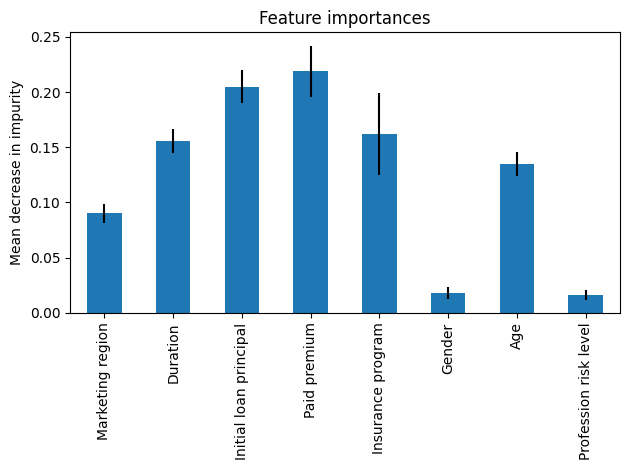

In [41]:
# visualize feature importance

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(model.feature_importances_, index=names[:8])

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [42]:
# select features based on importance

fi_selX = X[:,[1,2,3,4]]

# 3. Building ML algorithms

## 3.1. Validation setup

The most important issue which needs to be tackled in supervised ML models is overfitting. Overfitting happens when model does not generalize well from observed data to unseen data.

To avoid this, basic approach in machine learning is to randomly split dataset in test and train data. A model should be trained using train data, and then its performance should be evaluated on testing data to check generalization. In this research we will use test-train split in proportion 0.33-0.64.

In [43]:
# Test-train split setup

from sklearn.model_selection import train_test_split

test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

However, test-train split has its limitations, especially when dataset is not big enough: test dataset may be not representative. K-Fold cross-validation technique helps to fix this issue. 

It randomly splits the dataset into k equally sized chunks. The model is trained and evaluated k times, where each time it is trained on k-1 chunks and validated on the remaining. This process ensures that every data point in the dataset is used for both training and validation. The performance metrics are then averaged to provide a more reliable estimate of the model's generalization performance.

K-fold cross-validation with k = 10 is considered as gold standard and will be used in this research.

In [44]:
# KFold setup

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, shuffle=True)

In this research we need to focus on accuracy and recall rate. This information can be obtained via classification report, and we will setup specific function to get classification reports while using k-fold cross-validation.

In [45]:
# Function for classification_report on KFold

from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

## 3.2. Model 1: Logistic regression

The most common and basic supervised algorithm for binary classification is logistic regression. It estimates the probability of an instance belonging to a particular class using the logistic function. If the probability is higher than 50%, the model predicts it belongs to class 1. Otherwise, it predicts that the instance belongs to class 0.

In [102]:
# setup model

model = LogisticRegression()

Fit the model, predict results and print classification report.

In [103]:
# train on test-train split

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.69      0.48      0.57      1288
         1.0       0.60      0.78      0.68      1271

    accuracy                           0.63      2559
   macro avg       0.64      0.63      0.62      2559
weighted avg       0.64      0.63      0.62      2559



Visualize confusion matrix

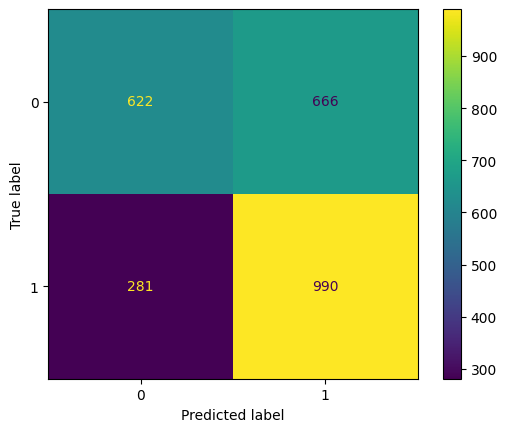

In [48]:
matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

calculate and visualize AUC and ROC

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.633


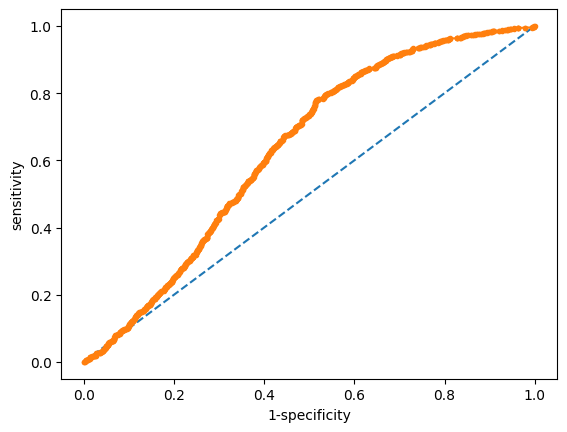

In [50]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

First approach is to build logistic regression with default hyperparameters on test-train split provides quite fair results. 

In [51]:
# try to use rescaled X

originalclass = []
predictedclass = []

results = cross_val_score(model, rescaledX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59      3877
         1.0       0.60      0.66      0.63      3877

    accuracy                           0.61      7754
   macro avg       0.61      0.61      0.61      7754
weighted avg       0.61      0.61      0.61      7754



In [52]:
# try to use selected features: RFE

originalclass = []
predictedclass = []

results = cross_val_score(model, rfe_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.52      0.68      0.59      3877
         1.0       0.54      0.37      0.44      3877

    accuracy                           0.53      7754
   macro avg       0.53      0.53      0.51      7754
weighted avg       0.53      0.53      0.51      7754



In [53]:
# try to use selected features: chi2

originalclass = []
predictedclass = []

results = cross_val_score(model, chi2_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      3877
         1.0       0.00      0.00      0.00      3877

    accuracy                           0.50      7754
   macro avg       0.25      0.50      0.33      7754
weighted avg       0.25      0.50      0.33      7754



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [54]:
# try to use selected features: feature importance

originalclass = []
predictedclass = []

results = cross_val_score(model, fi_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))



              precision    recall  f1-score   support

         0.0       0.65      0.47      0.55      3877
         1.0       0.58      0.74      0.65      3877

    accuracy                           0.61      7754
   macro avg       0.61      0.61      0.60      7754
weighted avg       0.61      0.61      0.60      7754



Usage of rescaled dataset or selected features does not bring any significant improvement.

In [109]:
# try to fine tune hyperparameters

model = LogisticRegression(solver='liblinear', C=100)

# train on test-train split

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.69      0.48      0.57      1288
         1.0       0.60      0.78      0.68      1271

    accuracy                           0.63      2559
   macro avg       0.64      0.63      0.62      2559
weighted avg       0.64      0.63      0.62      2559



Change of key hyperparameters provides same result.

## 3.3. Model 2: Decision Tree



Another classic algorithm for binary classification tasks is decision tree. This algorithm starts with the selection of the most informative feature that best splits the dataset into two subsets based on certain criteria, such as information gain or Gini impurity. Then it recursively splits the subsets using the same logic, and so on.

In [55]:
# setup model

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [56]:
#train on test-train split

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)


              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61      1288
         1.0       0.61      0.63      0.62      1271

    accuracy                           0.62      2559
   macro avg       0.62      0.62      0.62      2559
weighted avg       0.62      0.62      0.62      2559



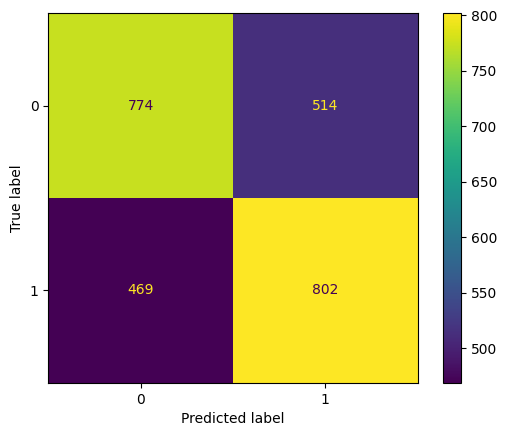

In [57]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [58]:
# Area Under Curve calculation

# predict probabilities
probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.616


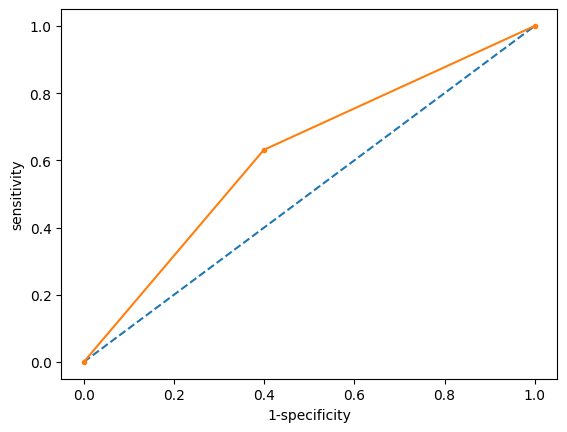

In [59]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

In [60]:
# try to use selected features: chi2

originalclass = []
predictedclass = []

results = cross_val_score(model, chi2_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.61      0.63      0.62      3877
         1.0       0.61      0.59      0.60      3877

    accuracy                           0.61      7754
   macro avg       0.61      0.61      0.61      7754
weighted avg       0.61      0.61      0.61      7754



In [61]:
# try to use selected features: rfe

originalclass = []
predictedclass = []

results = cross_val_score(model, rfe_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      3877
         1.0       0.61      0.61      0.61      3877

    accuracy                           0.61      7754
   macro avg       0.61      0.61      0.61      7754
weighted avg       0.61      0.61      0.61      7754



In [62]:
# try to use selected features: feature importance

originalclass = []
predictedclass = []

results = cross_val_score(model, fi_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62      3877
         1.0       0.62      0.61      0.62      3877

    accuracy                           0.62      7754
   macro avg       0.62      0.62      0.62      7754
weighted avg       0.62      0.62      0.62      7754



Results are also not acceptable. But Decision Tree algorithm is very sensitive to its hyperparameters, especially on max_depth and max_leaf_nodes. So we will try to find best hyperparameters, focusing on recall rate.

In [63]:
from sklearn.model_selection import RandomizedSearchCV

# The varying parameters to test and choose the best from
criterion = ['gini', 'entropy', 'log_loss']
splitter = ['best', 'random']
max_depth = [1,20]
max_leaf_nodes = [2,3,5,10,20]
min_samples_leaf = [1,3,5,10,20]

param_grid = [dict(criterion=criterion), dict(splitter=splitter), dict(max_depth=max_depth), 
             dict(max_leaf_nodes=max_leaf_nodes), dict(min_samples_leaf=min_samples_leaf)]

model = DecisionTreeClassifier()

# setup serach with focus on recall rate

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='recall',error_score='raise',cv=10)
grid.fit(X_train, Y_train)

predicted = grid.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

# print findings of grid search

print("Best score", grid.best_score_)
print("Recommended criterion value", grid.best_estimator_.criterion)
print("Recommended splitter value", grid.best_estimator_.splitter)
print("Recommended max_depth value", grid.best_estimator_.max_depth)
print("Recommended max_leaf_nodes value", grid.best_estimator_.max_leaf_nodes)
print("Recommended min_samples_leaf value", grid.best_estimator_.min_samples_leaf)

              precision    recall  f1-score   support

         0.0       0.99      0.31      0.48      1288
         1.0       0.59      1.00      0.74      1271

    accuracy                           0.65      2559
   macro avg       0.79      0.65      0.61      2559
weighted avg       0.79      0.65      0.61      2559

Best score 0.9953964043619216
Recommended criterion value gini
Recommended splitter value best
Recommended max_depth value None
Recommended max_leaf_nodes value 2
Recommended min_samples_leaf value 1


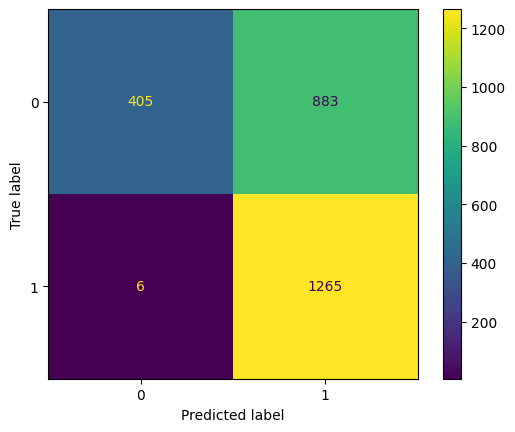

In [64]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [65]:
# Area Under Curve calculation

# predict probabilities
probs = grid.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.655


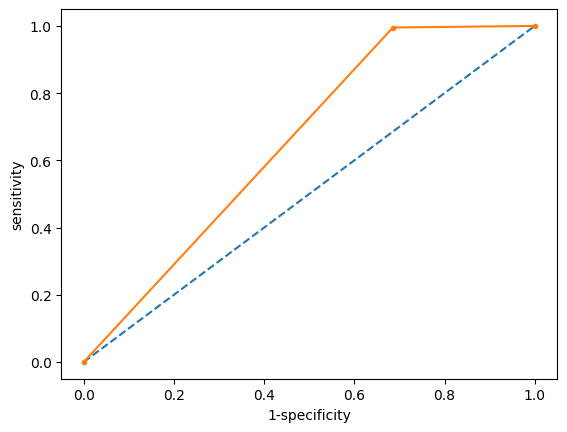

In [66]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

Results are much better. But now we must ensure that the model does not overfit.

Finally we train model with found parameters with KFold (k=10), to ensure generalization.

In [67]:
originalclass = []
predictedclass = []

model = DecisionTreeClassifier(criterion = "gini", splitter = 'best', max_depth=None, max_leaf_nodes = 2, min_samples_leaf = 1)

results = cross_val_score(model, X, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.99      0.32      0.48      3877
         1.0       0.59      1.00      0.74      3877

    accuracy                           0.66      7754
   macro avg       0.79      0.66      0.61      7754
weighted avg       0.79      0.66      0.61      7754



So with certain parameters it is possible to train Decision Tree model to find 1s with recall value of 1 and accuracy close to 66%.

## 3.4. Model 3: K-Nearest Neighbors


KNN algorithm uses distance measures like Euclidean distance to calculate the proximity between instances. Then it counts the labels of the k nearest neighbors and assigns the most common label as the predicted label for the new instance.

In [68]:
# setup model

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()


In [69]:
# train on test-train split

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)


              precision    recall  f1-score   support

         0.0       0.61      0.51      0.56      1288
         1.0       0.57      0.66      0.61      1271

    accuracy                           0.59      2559
   macro avg       0.59      0.59      0.59      2559
weighted avg       0.59      0.59      0.59      2559



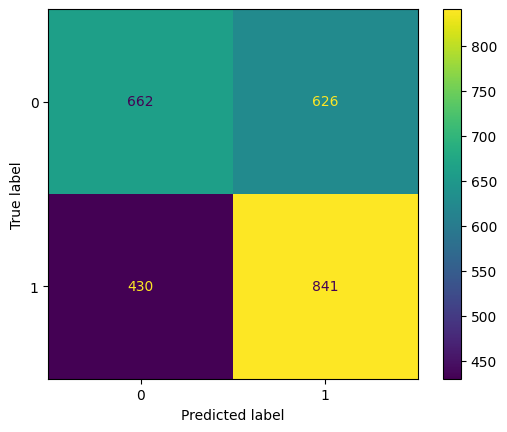

In [70]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [71]:
# Area Under Curve calculation

# predict probabilities
probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.621


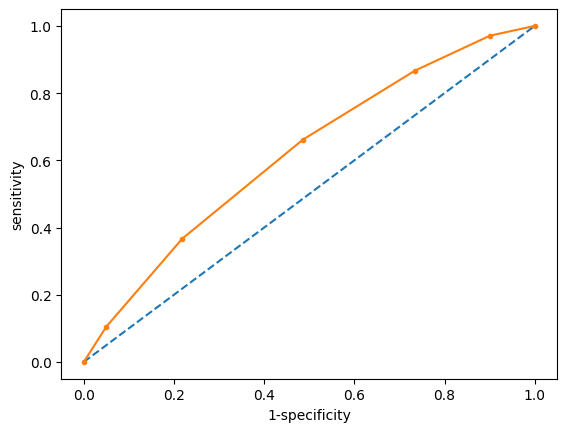

In [72]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

In [73]:
# try to use rescaled X

originalclass = []
predictedclass = []

results = cross_val_score(model, rescaledX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62      3877
         1.0       0.63      0.71      0.67      3877

    accuracy                           0.64      7754
   macro avg       0.65      0.64      0.64      7754
weighted avg       0.65      0.64      0.64      7754



In [74]:
# try to use selected features: chi2

originalclass = []
predictedclass = []

results = cross_val_score(model, chi2_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54      3877
         1.0       0.56      0.63      0.59      3877

    accuracy                           0.57      7754
   macro avg       0.57      0.57      0.57      7754
weighted avg       0.57      0.57      0.57      7754



In [75]:
# try to use selected features: rfe

originalclass = []
predictedclass = []

results = cross_val_score(model, rfe_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.62      0.54      0.58      3877
         1.0       0.59      0.66      0.62      3877

    accuracy                           0.60      7754
   macro avg       0.60      0.60      0.60      7754
weighted avg       0.60      0.60      0.60      7754



In [76]:
# try to use selected features: feature importance

originalclass = []
predictedclass = []

results = cross_val_score(model, fi_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.61      0.53      0.57      3877
         1.0       0.58      0.66      0.62      3877

    accuracy                           0.59      7754
   macro avg       0.60      0.59      0.59      7754
weighted avg       0.60      0.59      0.59      7754



Accuracy of the model is far below our target, hence it makes no sence to continue with KNN.

## 3.5. Model 4: Bagging. Random Forest

In bagging same algorithm is trained several times on different randomly split subsets, and results are aggregated. Sampling is done with replacement; hence the name of the method is short for “bootstrap aggregating”.

One example of bagging is Random Forest, which consist of many Decision Trees, each trained on its own split of dataset; prediction is done by majority of votes.

In [77]:
from sklearn.ensemble import RandomForestClassifier

# setup model

model = RandomForestClassifier() 


In [78]:
# train on test-train split

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)


              precision    recall  f1-score   support

         0.0       0.71      0.58      0.64      1288
         1.0       0.64      0.76      0.69      1271

    accuracy                           0.67      2559
   macro avg       0.67      0.67      0.67      2559
weighted avg       0.67      0.67      0.67      2559



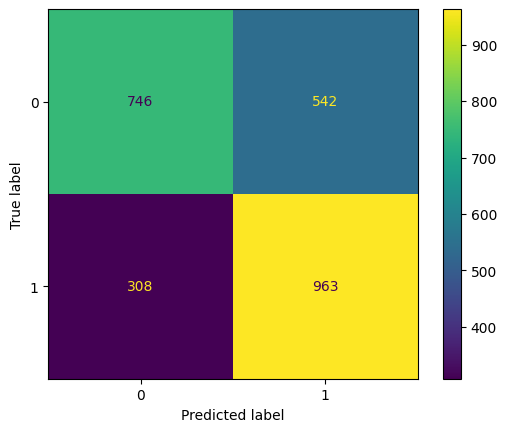

In [79]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [80]:
# Area Under Curve calculation

# predict probabilities
probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.715


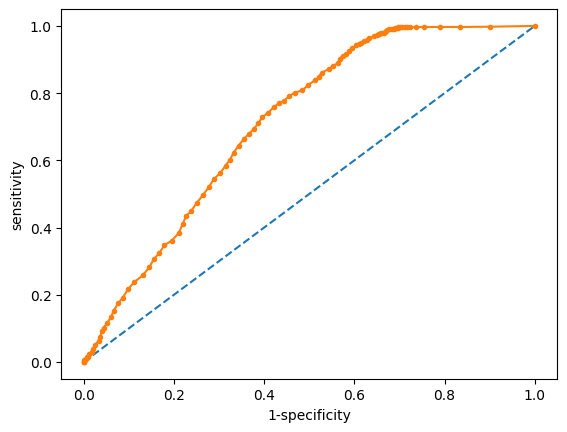

In [81]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

In [82]:
# try to use rescaled X

originalclass = []
predictedclass = []

results = cross_val_score(model, rescaledX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.71      0.58      0.64      3877
         1.0       0.65      0.76      0.70      3877

    accuracy                           0.67      7754
   macro avg       0.68      0.67      0.67      7754
weighted avg       0.68      0.67      0.67      7754



In [83]:
# try to use selected features: chi2

originalclass = []
predictedclass = []

results = cross_val_score(model, chi2_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.63      0.60      0.62      3877
         1.0       0.62      0.65      0.63      3877

    accuracy                           0.63      7754
   macro avg       0.63      0.63      0.63      7754
weighted avg       0.63      0.63      0.63      7754



In [84]:
# try to use selected features: rfe

originalclass = []
predictedclass = []

results = cross_val_score(model, rfe_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.65      0.58      0.62      3877
         1.0       0.62      0.69      0.65      3877

    accuracy                           0.64      7754
   macro avg       0.64      0.64      0.63      7754
weighted avg       0.64      0.64      0.63      7754



In [85]:
# try to use selected features: feature importance

originalclass = []
predictedclass = []

results = cross_val_score(model, fi_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.67      0.58      0.62      3877
         1.0       0.63      0.71      0.67      3877

    accuracy                           0.65      7754
   macro avg       0.65      0.65      0.64      7754
weighted avg       0.65      0.65      0.64      7754



Random Forest also provides quite robust results. It makes sence to fine tune its hyperparameters.

In [86]:
from sklearn.model_selection import RandomizedSearchCV

# The varying parameters to test and choose the best from
n_estimators = [10,250]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [1,20]
max_leaf_nodes = [2,3,5,10,20]
min_samples_leaf = [1,3,5,10,20]

param_grid = [dict(n_estimators=n_estimators), dict(criterion=criterion), dict(max_depth=max_depth), 
             dict(max_leaf_nodes=max_leaf_nodes), dict(min_samples_leaf=min_samples_leaf)]

model = RandomForestClassifier()

# setup serach with focus on recall rate

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                          scoring='recall',error_score='raise',cv=10)

grid.fit(X_train, Y_train)

predicted = grid.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

# print findings of grid search

print("Best score", grid.best_score_)
print("Recommended n_estimators value", grid.best_estimator_.n_estimators)
print("Recommended criterion value", grid.best_estimator_.criterion)
print("Recommended max_depth value", grid.best_estimator_.max_depth)
print("Recommended max_leaf_nodes value", grid.best_estimator_.max_leaf_nodes)
print("Recommended min_samples_leaf value", grid.best_estimator_.min_samples_leaf)

              precision    recall  f1-score   support

         0.0       0.96      0.34      0.51      1288
         1.0       0.60      0.99      0.74      1271

    accuracy                           0.66      2559
   macro avg       0.78      0.66      0.62      2559
weighted avg       0.78      0.66      0.62      2559

Best score 0.9693073975832596
Recommended n_estimators value 100
Recommended criterion value gini
Recommended max_depth value None
Recommended max_leaf_nodes value 3
Recommended min_samples_leaf value 1


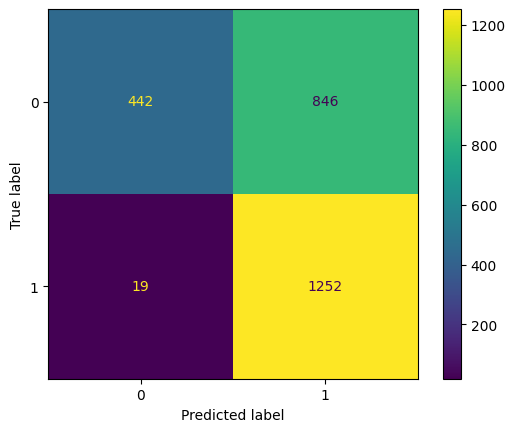

In [87]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [88]:
# Area Under Curve calculation

# predict probabilities
probs = grid.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.702


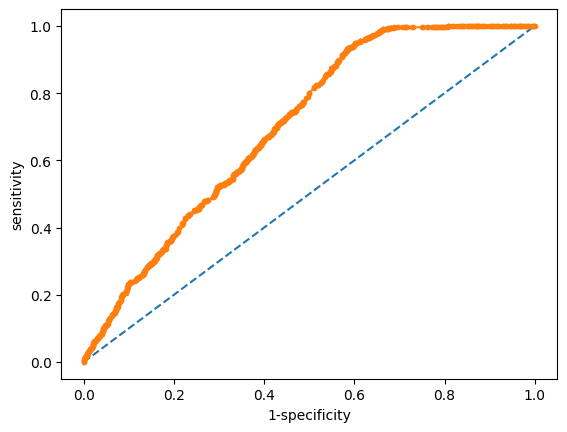

In [89]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

Random Forest results are pretty close to the ones of the Decision Tree.

## 3.6. Model 5: Voting Classifier

In voting different algorithms are trained on the same dataset. Each algorithm works independent and makes prediction - votes. The voting classifier combines the predictions of the individual classifiers using a hard (majority) voting or soft (weighted) voting approach.

In [90]:
from sklearn.ensemble import VotingClassifier

# setup 2 stacked models
 
dt = DecisionTreeClassifier(criterion = "gini", splitter = 'best', max_leaf_nodes = 2, min_samples_leaf = 1)
kn = KNeighborsClassifier()
lr = LogisticRegression()

estimators = [('KN', kn), ('DT', dt), ('LR', lr)]

# setup joint model

model = VotingClassifier(estimators=estimators,voting='hard')

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.40      0.53      1288
         1.0       0.60      0.91      0.72      1271

    accuracy                           0.65      2559
   macro avg       0.70      0.65      0.63      2559
weighted avg       0.70      0.65      0.62      2559



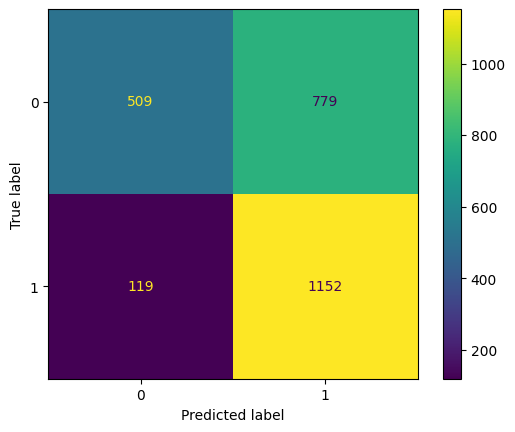

In [91]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

Voting did not improve the model.

## 3.7. Boosting: AdaBoost

In boosting one or several algorithms run consequently on the same dataset, each trying to correct its predecessor. Example of boosting algorithm is AdaBoost (short for Adaptive Boosting). This algorithm trains a weak base classifier (by default – Decision Tree with max_depth = 1), and makes prediction on the training set. Then it increases the relative weight of misclassified training instances, and trains second classifier with updated weights, and so on.

In [92]:
# setup model

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()


In [93]:
# fit model

model.fit(X_train, Y_train)

# predict based on test data

predicted = model.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.77      0.50      0.61      1288
         1.0       0.63      0.85      0.72      1271

    accuracy                           0.68      2559
   macro avg       0.70      0.68      0.67      2559
weighted avg       0.70      0.68      0.67      2559



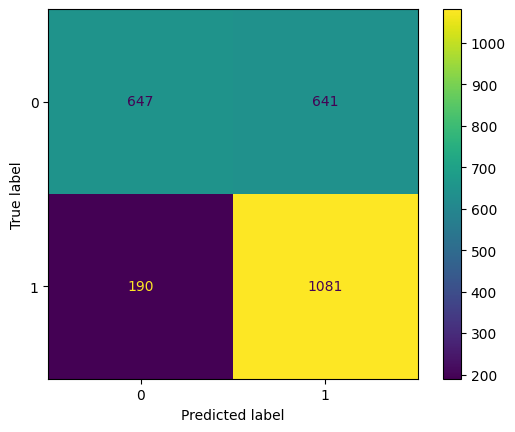

In [94]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

Two important hyperparameters of AdaBoost are n_estimators (number of trees) and learning rate. Let's try to use its best coherence using grid search.

In [95]:
from sklearn.model_selection import GridSearchCV

# The varying parameters to test and choose the best from
n_estimators = np.array([10, 25, 50, 100, 200, 250])
learn_rates = np.array([0.1, 0.5, 1, 2, 2.5, 3])

param_grid = [dict(n_estimators=n_estimators), dict(learning_rate=learn_rates)]

model = AdaBoostClassifier()

# perform search with focus on recall rate

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall')
grid.fit(X_train, Y_train)

predicted = grid.predict(X_test)

# build classification report

report = classification_report(Y_test, predicted)
print(report)

# print findings of grid search

print("Best score", grid.best_score_)
print("Recommended n_estimators value", grid.best_estimator_.n_estimators)
print("Recommended learning rate value", grid.best_estimator_.learning_rate)

              precision    recall  f1-score   support

         0.0       0.99      0.31      0.48      1288
         1.0       0.59      1.00      0.74      1271

    accuracy                           0.65      2559
   macro avg       0.79      0.65      0.61      2559
weighted avg       0.79      0.65      0.61      2559

Best score 0.9953964156757193
Recommended n_estimators value 50
Recommended learning rate value 2.5


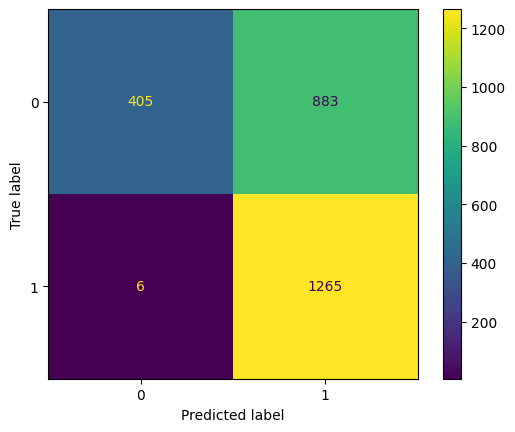

In [96]:
# build confusion matrix

matrix = confusion_matrix(Y_test, predicted)

matrix_disp = ConfusionMatrixDisplay(matrix)

matrix_disp.plot()

In [97]:
# Area Under Curve calculation

# predict probabilities
probs = grid.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(Y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.655


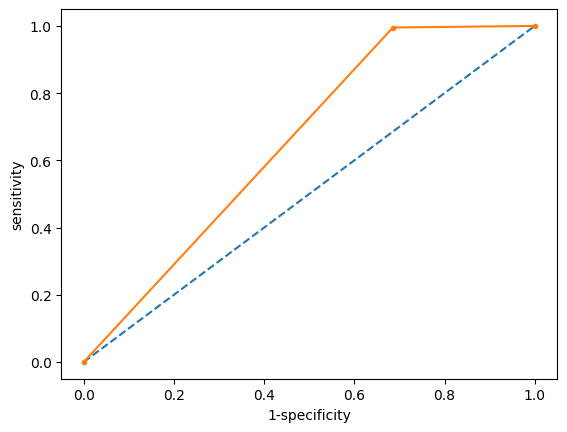

In [98]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(Y_test, probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')

pyplot.ylabel("sensitivity")
pyplot.xlabel("1-specificity")

pyplot.show()

In order to achieve the required result, we will train and test AdaBoost on subsets of selected features.

In [112]:
# try to use selected features: chi2

originalclass = []
predictedclass = []

model = AdaBoostClassifier(n_estimators=50, learning_rate=2.5)

results = cross_val_score(grid, chi2_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.99      0.32      0.48      3877
         1.0       0.59      1.00      0.74      3877

    accuracy                           0.66      7754
   macro avg       0.79      0.66      0.61      7754
weighted avg       0.79      0.66      0.61      7754



In [113]:
# try to use selected features: rfe

originalclass = []
predictedclass = []

model = AdaBoostClassifier(n_estimators=50, learning_rate=2.5)

results = cross_val_score(grid, rfe_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.99      0.32      0.48      3877
         1.0       0.59      1.00      0.74      3877

    accuracy                           0.66      7754
   macro avg       0.79      0.66      0.61      7754
weighted avg       0.79      0.66      0.61      7754



In [111]:
# try to use selected features: feature importance

originalclass = []
predictedclass = []

model = AdaBoostClassifier(n_estimators=50, learning_rate=2.5)

results = cross_val_score(grid, fi_selX, Y, cv=kfold, scoring=make_scorer(classification_report_with_accuracy_score))

print(classification_report(originalclass, predictedclass))

              precision    recall  f1-score   support

         0.0       0.99      0.32      0.48      3877
         1.0       0.59      1.00      0.74      3877

    accuracy                           0.66      7754
   macro avg       0.79      0.66      0.61      7754
weighted avg       0.79      0.66      0.61      7754



AdaBoost with n_estimators=50, learning_rate=2.5, using features selected by chi-squared, RFE or features importance, gives the required result.